## Imports

Set up Spark session

In [1]:
import pyspark.sql.types as pst
import pyspark.sql.functions as F
from pyspark.sql import Window

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050').set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')\
                  .set('spark.dynamicAllocation.enabled', 'true')\
                  .set('spark.shuffle.service.enabled', 'true')
sc = SparkContext(conf=conf)
ss = SparkSession.builder.master('local[*]').getOrCreate()

In [3]:
ss

In [4]:
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.grid': True,
    'figure.figsize': [6, 4],
})

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## EDA

### targets

In [5]:
from huggingface_hub import snapshot_download, hf_hub_download

In [6]:
hf_hub_download(repo_id="ai-lab/MBD-mini", filename="targets.tar.gz", repo_type="dataset", local_dir='data')
!tar -xf ./data/targets.tar.gz

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


targets.tar.gz:   0%|          | 0.00/7.93M [00:00<?, ?B/s]

In [7]:
targets = ss.read.parquet('targets')

In [8]:
targets.count()

1202688

In [ ]:
targets.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- mon: string (nullable = true)
 |-- bcard_target: integer (nullable = true)
 |-- cred_target: integer (nullable = true)
 |-- zp_target: integer (nullable = true)
 |-- acquiring_target: integer (nullable = true)
 |-- trans_count: integer (nullable = true)
 |-- diff_trans_date: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)
 |-- fold: integer (nullable = true)



Distribution of number of transactions for client in report month

<Axes: ylabel='Frequency'>

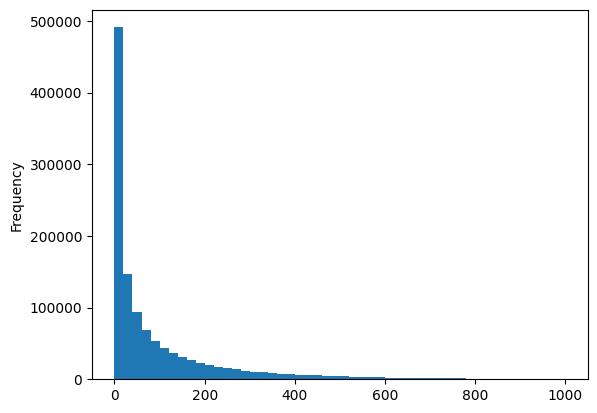

In [ ]:
targets.toPandas()['trans_count'].plot(kind='hist', bins=50)

Number of distinct clients

In [ ]:
targets\
    .select(F.countDistinct('client_id'))\
    .show()

+-------------------------+
|count(DISTINCT client_id)|
+-------------------------+
|                   100224|
+-------------------------+



In [ ]:
targets.show(n=5, truncate=False)

+----------------------------------------------------------------+----------+------------+-----------+---------+----------------+-----------+---------------+-----------------+----+
|client_id                                                       |mon       |bcard_target|cred_target|zp_target|acquiring_target|trans_count|diff_trans_date|__index_level_0__|fold|
+----------------------------------------------------------------+----------+------------+-----------+---------+----------------+-----------+---------------+-----------------+----+
|0000778662f0a7deffaedda7a66afcf008e9aaf6a2af110bf2a62e2572b2b8e4|2022-02-28|0           |0          |0        |0               |6          |10.0           |7200048          |3   |
|0000778662f0a7deffaedda7a66afcf008e9aaf6a2af110bf2a62e2572b2b8e4|2022-03-31|0           |0          |0        |0               |12         |12.0           |7200049          |3   |
|0000778662f0a7deffaedda7a66afcf008e9aaf6a2af110bf2a62e2572b2b8e4|2022-04-30|0           |0    

In [ ]:
trgt_names = ['bcard_target', 'cred_target', 'zp_target', 'acquiring_target']

Sum on all types of target. Class imbalance can be seen.

In [ ]:
targets\
    .withColumn('sum_target', F.expr("+".join(trgt_names)))\
    .groupBy('mon')\
    .agg(F.count('sum_target'), F.sum('sum_target'))\
    .orderBy('mon')\
    .show()

+----------+-----------------+---------------+
|       mon|count(sum_target)|sum(sum_target)|
+----------+-----------------+---------------+
|2022-02-28|          1000000|          10814|
|2022-03-31|          1000000|          16866|
|2022-04-30|          1000000|          17355|
|2022-05-31|          1000000|          11687|
|2022-06-30|          1000000|          12505|
|2022-07-31|          1000000|          10642|
|2022-08-31|          1000000|          12159|
|2022-09-30|          1000000|          10450|
|2022-10-31|          1000000|           8764|
|2022-11-30|          1000000|           9096|
|2022-12-31|          1000000|           8175|
|2023-01-31|          1000000|           6616|
+----------+-----------------+---------------+



Sum on each type of target

In [ ]:
targets\
    .withColumn('sum_target', F.expr("+".join(trgt_names)))\
    .groupBy('mon')\
    .agg(*[F.sum(nov) for nov in trgt_names])\
    .orderBy('mon')\
    .show()

+----------+-----------------+----------------+--------------+---------------------+
|       mon|sum(bcard_target)|sum(cred_target)|sum(zp_target)|sum(acquiring_target)|
+----------+-----------------+----------------+--------------+---------------------+
|2022-02-28|             5391|             352|          2816|                 2255|
|2022-03-31|             7169|             465|          6155|                 3077|
|2022-04-30|             6250|             757|          6844|                 3504|
|2022-05-31|             4723|             432|          4369|                 2163|
|2022-06-30|             6338|             541|          3261|                 2365|
|2022-07-31|             4649|             538|          3158|                 2297|
|2022-08-31|             4623|             553|          4096|                 2887|
|2022-09-30|             3368|             514|          4057|                 2511|
|2022-10-31|             3174|             443|          2767|   

### Training data

In [ ]:
hf_hub_download(repo_id="ai-lab/MBD-mini", filename="detail.tar.gz", repo_type="dataset", local_dir='data')
!tar -xf ./data/detail.tar.gz

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


detail.tar.gz:   0%|          | 0.00/1.97G [00:00<?, ?B/s]

In [ ]:
!du -h --max-depth=1 detail

644M	detail/dialog
647M	detail/trx
795M	detail/geo
2.1G	detail


#### Transactions

In [ ]:
trx = ss.read.parquet('detail/trx')

In [ ]:
trx.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- amount: float (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_subtype: integer (nullable = true)
 |-- currency: integer (nullable = true)
 |-- src_type11: integer (nullable = true)
 |-- src_type12: integer (nullable = true)
 |-- dst_type11: integer (nullable = true)
 |-- dst_type12: integer (nullable = true)
 |-- src_type21: integer (nullable = true)
 |-- src_type22: integer (nullable = true)
 |-- src_type31: integer (nullable = true)
 |-- src_type32: integer (nullable = true)
 |-- fold: integer (nullable = true)



In [ ]:
trx\
    .groupBy('client_id')\
    .agg(F.count("*").alias('trans_count'))\
    .write.parquet('trans_count.parquet', mode='overwrite')

Distribution of number of transactions for each client

In [ ]:
trans_count_pd = pd.read_parquet('trans_count.parquet')

In [ ]:
trans_count_pd['trans_count'].describe()

,trans_count
count,9.872100e+04
mean,3.926716e+02
std,3.717613e+03
min,1.000000e+00
25%,4.100000e+01
50%,1.700000e+02
75%,5.110000e+02
max,1.020773e+06


<Axes: ylabel='Frequency'>

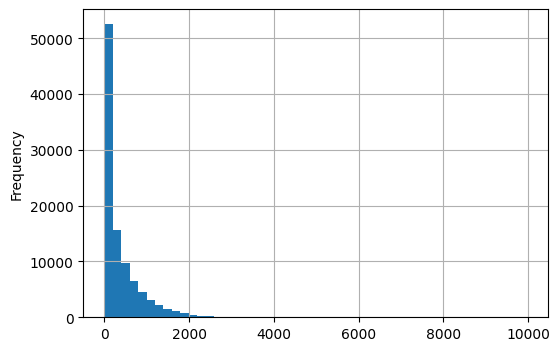

In [ ]:
trans_count_pd = pd.read_parquet('trans_count.parquet')

# exclude outliers
trans_count_pd.query("trans_count < 1e4")['trans_count'].plot(kind='hist', bins=50)

In [ ]:
trx.show(5, True)

+--------------------+--------------------+---------+----------+-------------+--------+----------+----------+----------+----------+----------+----------+----------+----------+----+
|           client_id|          event_time|   amount|event_type|event_subtype|currency|src_type11|src_type12|dst_type11|dst_type12|src_type21|src_type22|src_type31|src_type32|fold|
+--------------------+--------------------+---------+----------+-------------+--------+----------+----------+----------+----------+----------+----------+----------+----------+----+
|086a7ed4269224ff8...|2021-09-03 12:18:...|308.71454|        40|           52|      11|        22|        47|      1549|     16067|      5857|        15|       352|        67|   3|
|086a7ed4269224ff8...|2022-04-30 21:43:...| 4844.122|        40|           37|      11|       134|       806|      1549|     16067|      5857|        15|       352|        67|   3|
|086a7ed4269224ff8...|2022-07-16 14:42:...|2507.5642|        40|           37|      11|       1

In [ ]:
print('event time spread')
trx\
    .select(F.min('event_time'), F.max('event_time'))\
    .show()

event time spread
+--------------------+--------------------+
|     min(event_time)|     max(event_time)|
+--------------------+--------------------+
|2020-12-31 21:00:...|2022-12-31 20:59:...|
+--------------------+--------------------+



Transactions history starts more than one year before target period start and finshes one month before target period end

In [ ]:
trx\
    .select(F.min('amount'), F.percentile_approx('amount', 0.5), F.max('amount'))\
    .show()

+------------+-------------------------------------+-------------+
| min(amount)|percentile_approx(amount, 0.5, 10000)|  max(amount)|
+------------+-------------------------------------+-------------+
|3.0218207E-6|                            18029.834|1.37018737E12|
+------------+-------------------------------------+-------------+



Number of categories for categorical variables

In [ ]:
cat_feats_trx = ['event_type', 'event_subtype', 'currency', 'src_type11', 'src_type12', 'dst_type11', 'dst_type12', 'src_type21', 'src_type22', 'src_type31', 'src_type32']

In [ ]:
trx\
    .select(*[F.countDistinct(x).alias(x) for x in cat_feats_trx])\
    .show()

+----------+-------------+--------+----------+----------+----------+----------+----------+----------+----------+----------+
|event_type|event_subtype|currency|src_type11|src_type12|dst_type11|dst_type12|src_type21|src_type22|src_type31|src_type32|
+----------+-------------+--------+----------+----------+----------+----------+----------+----------+----------+----------+
|        55|           60|      13|        60|       262|        66|       322|     10081|        85|      1722|        86|
+----------+-------------+--------+----------+----------+----------+----------+----------+----------+----------+----------+



`src_type22` and `src_type32` look like region index according to cardinality

Search for potential categorical features for ML model that will be built on transaction aggregates: analyze skewness of distribution in categorical sequences

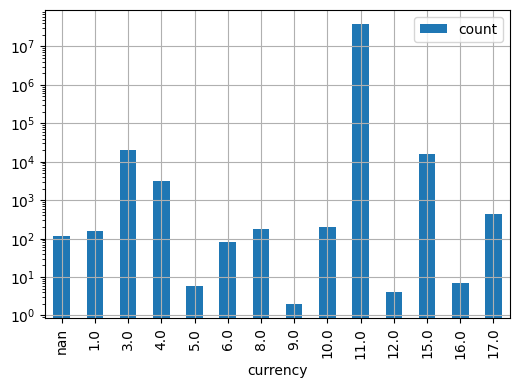

In [ ]:
fig, ax = plt.subplots()

trx\
    .groupBy('currency')\
    .count()\
    .orderBy('currency')\
    .toPandas()\
    .set_index('currency')\
    .plot(kind='bar', ax=ax)

ax.set_yscale('log')

Currency looks too skewed. Intuitively, most of transactions may be conducted in Russia and currency will be RUR. Therefore, it isn't most frequent value of currency will be the same for most of the clients.

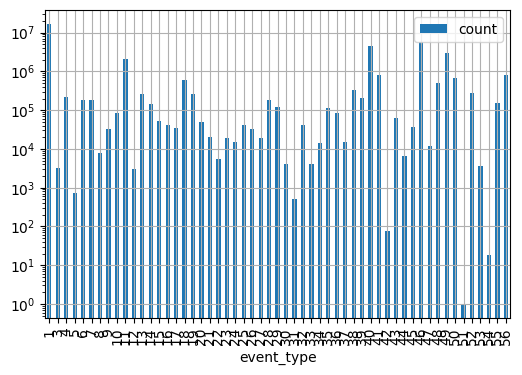

In [ ]:
nov = 'event_type'

fig, ax = plt.subplots()

trx\
    .groupBy(nov)\
    .count()\
    .orderBy(nov)\
    .toPandas()\
    .set_index(nov)\
    .plot(kind='bar', ax=ax)

ax.set_yscale('log')

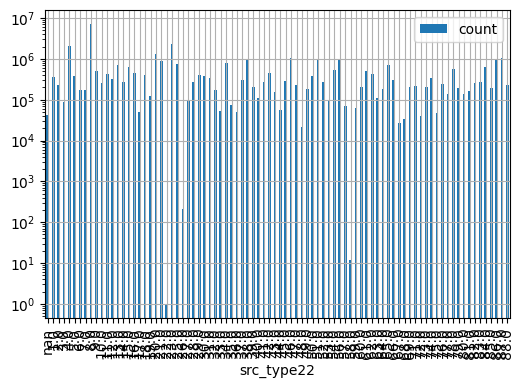

In [ ]:
nov = 'src_type22'

fig, ax = plt.subplots()

trx\
    .groupBy(nov)\
    .count()\
    .orderBy(nov)\
    .toPandas()\
    .set_index(nov)\
    .plot(kind='bar', ax=ax)

ax.set_yscale('log')

`event_type` and `src_type` look appropriate for categorical features

In [ ]:
trx\
    .select(F.countDistinct('client_id'))\
    .show()

+-------------------------+
|count(DISTINCT client_id)|
+-------------------------+
|                    98721|
+-------------------------+



#### dialogs

In [ ]:
dialog = ss.read.parquet('detail/dialog')

In [ ]:
dialog.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- fold: integer (nullable = true)



In [ ]:
dialog.show(3, False)

+----------------------------------------------------------------+--------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### geo

In [ ]:
geo = ss.read.parquet('detail/geo')

In [ ]:
geo.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- geohash_4: integer (nullable = true)
 |-- geohash_5: integer (nullable = true)
 |-- geohash_6: integer (nullable = true)
 |-- fold: integer (nullable = true)



In [ ]:
geo.show(3, False)

+----------------------------------------------------------------+--------------------------+---------+---------+---------+----+
|client_id                                                       |event_time                |geohash_4|geohash_5|geohash_6|fold|
+----------------------------------------------------------------+--------------------------+---------+---------+---------+----+
|17883fdcd58fce22a9ad28bf2ad57a3c9e05542bc0c4b61a90f9a0ba48f07262|2022-11-21 06:36:47.25692 |6219     |373170   |1140355  |4   |
|17883fdcd58fce22a9ad28bf2ad57a3c9e05542bc0c4b61a90f9a0ba48f07262|2022-04-06 08:26:52.640751|6219     |169048   |1511168  |4   |
|17883fdcd58fce22a9ad28bf2ad57a3c9e05542bc0c4b61a90f9a0ba48f07262|2022-03-03 08:28:47.372397|6219     |169048   |1511168  |4   |
+----------------------------------------------------------------+--------------------------+---------+---------+---------+----+
only showing top 3 rows



In [ ]:
geo\
    .select(F.countDistinct('geohash_4'))\
    .show()

+-------------------------+
|count(DISTINCT geohash_4)|
+-------------------------+
|                    18948|
+-------------------------+



In [ ]:
!pip install pygeohash -q
import pygeohash as pgh

In [ ]:
pgh.decode('6219')

(-45.0, -76.0)

In [ ]:
print(pgh.decode('373170'))
print(pgh.decode('169048'))

(-26.5, -122.2)
(-75.93, -122.2)


## Preprocessing


### Transactions

Aggregate transactions for each report month.  
Transactions are aggregated on span of 1, 3 and 6 months before report date. Min, max and cnt aggregation functions are applied

In [ ]:
report_dts = pd.date_range('2022-02-28', '2023-01-31', freq='ME').strftime('%Y-%m-%d').tolist()

In [ ]:
trx_amt_agg_fns = [
    F.sum('flag_1m').alias('trx_cnt_1m'),
    F.sum(F.expr('flag_1m * amount')).alias('trx_sum_1m'),
    F.max(F.expr('flag_1m * amount')).alias('trx_max_1m'),

    F.sum('flag_3m').alias('trx_cnt_3m'),
    F.sum(F.expr('flag_3m * amount')).alias('trx_sum_3m'),
    F.max(F.expr('flag_3m * amount')).alias('trx_max_3m'),

    F.sum('flag_6m').alias('trx_cnt_6m'),
    F.sum(F.expr('flag_6m * amount')).alias('trx_sum_6m'),
    F.max(F.expr('flag_6m * amount')).alias('trx_max_6m'),


]

In [27]:
%%time

for report_dt in tqdm(report_dts):
    trx_preagg = trx\
        .withColumn('mon', F.lit(report_dt).cast(pst.DateType()))\
        .filter("last_day(add_months(last_day(event_time), -1)) < mon")\
        .withColumn('flag_1m', F.when(F.expr("months_between(cast(date_format(mon, 'yyyy-MM') as date), event_time) < 1"), 1).otherwise(0))\
        .withColumn('flag_3m', F.when(F.expr("months_between(cast(date_format(mon, 'yyyy-MM') as date), event_time) < 3"), 1).otherwise(0))\
        .withColumn('flag_6m', F.when(F.expr("months_between(cast(date_format(mon, 'yyyy-MM') as date), event_time) < 6"), 1).otherwise(0))

    trx_agg_amt = trx_preagg\
        .groupBy('client_id', 'mon')\
        .agg(*trx_amt_agg_fns)

    trx_agg_et = trx_preagg\
        .withColumn('count_event_type', F.count("*").over(Window.partitionBy('client_id', 'mon', 'event_type')))\
        .withColumn('rn', F.row_number().over(Window.partitionBy('client_id', 'mon').orderBy(F.col('count_event_type').desc())))\
        .filter("rn = 1")\
        .select('client_id', 'mon', F.col('event_type').alias('trx_et_mode'))

    trx_agg_est = trx_preagg\
        .withColumn('count_event_subtype', F.count("*").over(Window.partitionBy('client_id', 'mon', 'event_subtype')))\
        .withColumn('rn', F.row_number().over(Window.partitionBy('client_id', 'mon').orderBy(F.col('count_event_subtype').desc())))\
        .filter("rn = 1")\
        .select('client_id', 'mon', F.col('event_type').alias('trx_est_mode'))

    trx_agg_src22 = trx_preagg\
        .withColumn('count_src_type22', F.count("*").over(Window.partitionBy('client_id', 'mon', 'src_type22')))\
        .withColumn('rn', F.row_number().over(Window.partitionBy('client_id', 'mon').orderBy(F.col('count_src_type22').desc())))\
        .filter("rn = 1")\
        .select('client_id', 'mon', F.col('event_type').alias('trx_src22_mode'))

    trx_agg_src32 = trx_preagg\
        .withColumn('count_src_type32', F.count("*").over(Window.partitionBy('client_id', 'mon', 'src_type32')))\
        .withColumn('rn', F.row_number().over(Window.partitionBy('client_id', 'mon').orderBy(F.col('count_src_type32').desc())))\
        .filter("rn = 1")\
        .select('client_id', 'mon', F.col('event_type').alias('trx_src32_mode'))

    trx_agg_mon = trx_agg_amt\
        .join(trx_agg_et, on=['client_id', 'mon'], how='left')\
        .join(trx_agg_est, on=['client_id', 'mon'], how='left')\
        .join(trx_agg_src22, on=['client_id', 'mon'], how='left')\
        .join(trx_agg_src32, on=['client_id', 'mon'], how='left')

    trx_agg_mon.write.parquet(f'drive/MyDrive/SberIndexTest/data/preproc/trx_agg/{report_dt}.parquet', mode='overwrite')

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 14.7 s, sys: 2.18 s, total: 16.9 s
Wall time: 1h 25min 30s


### Dialog

#### Last pooling

In [ ]:
dialog.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- fold: integer (nullable = true)



* For each report month, extract dialogs before the beginning of this month exclusively
* Take last dialog in this period with window function

In [29]:
for report_dt in tqdm(report_dts):
    dialog_preagg = dialog\
        .withColumn('mon', F.lit(report_dt).cast(pst.StringType()))\
        .filter('last_day(add_months(last_day(event_time), -1)) < mon')
    dialog_mon_last = dialog_preagg\
        .withColumn('rn', F.row_number().over(Window.partitionBy('client_id', 'mon').orderBy(F.col('event_time').desc())))\
        .filter('rn = 1')\
        .select('client_id', 'event_time', 'mon', 'embedding')

    dialog_mon_last.write.parquet(f'drive/MyDrive/SberIndexTest/data/preproc/dialog_agg/{report_dt}.parquet', mode="overwrite")

  0%|          | 0/12 [00:00<?, ?it/s]

In [30]:
dialog_last_pd = pd.read_parquet(f'drive/MyDrive/SberIndexTest/data/preproc/dialog_agg')

In [31]:
dialog_last_pd

,client_id,event_time,mon,embedding
0,00088f1d5f1d3aec81bec9e3380085c9d644b004638fdf...,2021-12-29 05:44:27.896522,2022-02-28,"[0.37322193, -0.19808462, 0.509121, -0.3556997..."
1,000ce17c51f6a193c1f138cd17365587506c5f9502e685...,2021-11-16 13:12:05.414712,2022-02-28,"[0.56099665, -0.33282652, 0.71185464, -0.58383..."
2,000dbaa90a072f55e52c07acf8b6ab77b674841b03fba9...,2021-04-30 06:18:59.381658,2022-02-28,"[0.25380474, -0.021852743, 0.41790318, -0.3006..."
3,000f4309610cc90124943138fdf6d50a2b5967a9ba79b2...,2021-11-20 12:08:15.119988,2022-02-28,"[0.35111684, 0.082568765, 0.3714127, -0.172357..."
4,000fff599dacf53fffcf4663ab370d21921d1988f8cfad...,2021-04-14 15:10:13.392665,2022-02-28,"[0.39002457, -0.15838914, 0.46159643, -0.31632..."
...,...,...,...,...
470079,ffd3277ddee2bb46e4bdc21b003ebaaa66bc3718abee9a...,2022-09-20 02:40:55.829964,2023-01-31,"[0.348974, -0.013922471, 0.49128702, -0.390436..."
470080,ffd4b9cadbe02512fe0c14901147643000ec82d5808415...,2022-11-29 08:49:43.086152,2023-01-31,"[0.4460622, -0.28840736, 0.73499227, -0.432672..."
470081,ffdae6fa23ec4f29897a48d02530a9a67189ab877956da...,2022-11-27 10:01:43.915668,2023-01-31,"[0.26631433, -0.16096947, 0.4497849, -0.309470..."
470082,ffdbb5486e1dda5674f66857e145aeef011374d4d6975c...,2022-12-20 08:08:46.956690,2023-01-31,"[0.0016724527, 0.091411255, 0.21659157, 0.0182..."


#### Dimensionality reduction

Extract embedding vector into dataframe columns

In [2]:
dialog_last = pd.read_parquet(f'drive/MyDrive/SberIndexTest/data/preproc/dialog_agg')

In [5]:
dialog_last.head()

,client_id,event_time,mon,embedding
0,00088f1d5f1d3aec81bec9e3380085c9d644b004638fdf...,2021-12-29 05:44:27.896522,2022-02-28,"[0.37322193, -0.19808462, 0.509121, -0.3556997..."
1,000ce17c51f6a193c1f138cd17365587506c5f9502e685...,2021-11-16 13:12:05.414712,2022-02-28,"[0.56099665, -0.33282652, 0.71185464, -0.58383..."
2,000dbaa90a072f55e52c07acf8b6ab77b674841b03fba9...,2021-04-30 06:18:59.381658,2022-02-28,"[0.25380474, -0.021852743, 0.41790318, -0.3006..."
3,000f4309610cc90124943138fdf6d50a2b5967a9ba79b2...,2021-11-20 12:08:15.119988,2022-02-28,"[0.35111684, 0.082568765, 0.3714127, -0.172357..."
4,000fff599dacf53fffcf4663ab370d21921d1988f8cfad...,2021-04-14 15:10:13.392665,2022-02-28,"[0.39002457, -0.15838914, 0.46159643, -0.31632..."


In [4]:
emb_size = 768
emb_names = [f"v_{i}" for i in range(emb_size)]

In [17]:
for g, gp in tqdm(dialog_last.groupby('mon'), total=12):
    dialog_last.loc[gp.index, emb_names] = pd.DataFrame(gp['embedding'].tolist()).to_numpy(copy=True)

  0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
pd.DataFrame(dialog_last.iloc[:2]['embedding'].tolist())

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.373222,-0.198085,0.509121,-0.355700,-0.275493,0.470878,0.255409,0.233914,-0.291920,0.237141,...,0.481588,0.383540,0.419249,0.978951,0.501454,0.044611,0.348542,-0.228381,0.498149,0.330902
1,0.560997,-0.332827,0.711855,-0.583839,-0.343269,0.715845,0.597566,0.558768,-0.419421,0.529774,...,0.700441,0.508623,0.432026,0.943314,0.620523,0.428605,0.403807,-0.481363,0.658970,0.504655


In [18]:
dialog_last\
    .drop(columns=['embedding'])\
    .to_parquet(f'drive/MyDrive/SberIndexTest/data/preproc/dialog_agg_768.parquet')

In [19]:
import gc
gc.collect()

142

In [21]:
dial_full = pd.read_parquet(f'drive/MyDrive/SberIndexTest/data/preproc/dialog_agg_768.parquet')

Apply principal components analysis to reduce embedding dimensionality to 8

In [6]:
from sklearn.decomposition import PCA

In [7]:
n_pc = 8
pca = PCA(n_components=n_pc, random_state=42)

In [8]:
emb_names_rdcd = [f"v_{i}" for i in range(n_pc)]

In [11]:
dial_rdcd = dial_full[['client_id', 'mon']].copy()

In [12]:
dial_rdcd[emb_names_rdcd] = pca.fit_transform(dial_full[emb_names])

In [13]:
dial_rdcd.to_parquet(f'drive/MyDrive/SberIndexTest/data/preproc/dialog_agg_8.parquet')